## Importing Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
from sklearn.model_selection import train_test_split
import os
from wrangle_zillow import wrangle_zillow, split_zillow, scale_data
import re
import PyPDF2

## Acquiring Clean Data

In [3]:
zillow = wrangle_zillow()

## Splitting the Data

In [5]:
train, validate, test = split_zillow(zillow, stratify_by = 'county')

## Explore

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='logerror', ylabel='Count'>

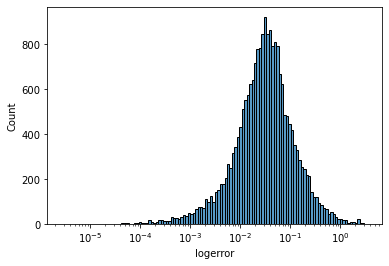

In [9]:
# Displaying a distribution of logerror

sns.histplot(train['logerror'], log_scale = True)

<AxesSubplot:xlabel='county', ylabel='logerror'>

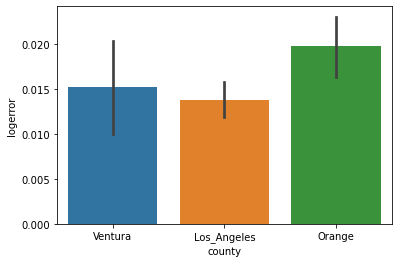

In [10]:
# Displaying the relationship between county and their relative logerror
#

sns.barplot(x = train['county'], y = train['logerror'])

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

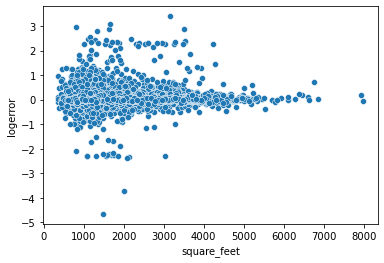

In [15]:
# Displaying relationship between square footage and logerror
# Note as square footage increases total error seems to go down

sns.scatterplot(x = train['square_feet'], y = train['logerror'])

In [13]:
zillow

,parcelid,logerror,transactiondate,bathrooms,bedrooms,buildingqualitytypeid,square_feet,fips,latitude,longitude,...,tax_value,assessmentyear,landtaxvaluedollarcnt,taxes,heatingorsystemdesc,county,age_in_years,Bathrooms_cat,Bedrooms_cat,tax_rate
0,14297519,0.025595,2017-01-01,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,...,1023282.0,2016.0,537569.0,11013.72,None,Orange,23.0,3.5,4+,1.08
1,17052889,0.055619,2017-01-01,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,...,464000.0,2016.0,376000.0,5672.48,None,Ventura,54.0,1,2,1.22
2,14186244,0.005383,2017-01-01,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,...,564778.0,2016.0,479489.0,6488.30,None,Orange,59.0,2,3,1.15
3,12177905,-0.103410,2017-01-01,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,...,145143.0,2016.0,36225.0,1777.51,Central,Los_Angeles,51.0,3,4+,1.22
4,10887214,0.006940,2017-01-01,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,...,119407.0,2016.0,45726.0,1533.89,Central,Los_Angeles,57.0,3,3,1.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77375,10833991,-0.002245,2017-09-20,3.0,3.0,8.0,1741.0,6037.0,34202400.0,-118502000.0,...,379000.0,2016.0,114000.0,4685.34,Central,Los_Angeles,41.0,3,3,1.24
77376,11000655,0.020615,2017-09-20,2.0,2.0,6.0,1286.0,6037.0,34245368.0,-118282383.0,...,354621.0,2016.0,283704.0,4478.43,Central,Los_Angeles,81.0,2,2,1.26
77377,17239384,0.013209,2017-09-21,2.0,4.0,6.0,1612.0,6111.0,34300140.0,-118706327.0,...,67205.0,2016.0,16522.0,1107.48,None,Ventura,57.0,2,4+,1.65
77378,12773139,0.037129,2017-09-21,1.0,3.0,4.0,1032.0,6037.0,34040895.0,-118038169.0,...,49546.0,2016.0,16749.0,876.43,Central,Los_Angeles,67.0,1,3,1.77
